In [151]:
import warnings
import time
import os

# RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
#     CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
#     GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
#     AWS_NO_SIGN_REQUEST="YES",
#     GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
#     GDAL_SWATH_SIZE="200000000",
#     VSI_CURL_CACHE_SIZE="200000000",
# )
# os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
# from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas as gpd
import dask_geopandas
# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc
from dask.distributed import Client, progress
import rioxarray

import sys
sys.path.insert(0, '/raster')
sys.path.insert(0, '/models')


In [2]:
def create_centroids_gdf(gdf):
    #Convert to equal area projection and back to avoid CRS issues with calculating centroid:
    c = kde_gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)

    centroids = pd.DataFrame()
    centroids['grid_id'] = gdf.grid_id
    centroids['lon'] = c.x.values
    centroids['lat'] = c.y.values
    centroids = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids['lon'], centroids['lat']))
    
    return centroids

def _query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull) #TODO replace with rectangular geometry

    search_start = "2019-01-01"
    search_end = "2019-12-31"
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                        modifier=pc.sign_inplace)
    # catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }

    index = []

    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = gpd.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)


dask_geopandas_partitions = 250

def add_sentinel_urls(centroids):
    
    print("Organizing grid centroids according to Hilbert distance...")

    ddf = dask_geopandas.from_geopandas(centroids, npartitions=1)
    hd = ddf.hilbert_distance().compute()
    centroids["hd"] = hd
    centroids = centroids.sort_values("hd")
    dgdf = dask_geopandas.from_geopandas(centroids, npartitions=dask_geopandas_partitions, sort=False)

    from dask_gateway import GatewayCluster
    
    try:
        print("Attemping to create a new dask client")
        cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
        client = cluster.get_client()
        cluster.adapt(minimum=4, maximum=113)

        print(cluster.dashboard_link)
        print(client)

        meta = dgdf._meta.assign(stac_item=[])
        df2 = dgdf.map_partitions(_query, meta=meta).compute()

        
        data = df2.dropna(subset=["stac_item"])
        #Save it as a tuple -> (RGB,NIR)
        data['urls'] = [(item["assets"]["visual"]["href"], item["assets"]["B08"]["href"]) for item in data.stac_item.tolist()]
        data['crs']  = [item["properties"]["proj:epsg"] for item in data.stac_item.tolist()]
        print(data.stac_item[0]["properties"]["proj:epsg"])
        print("{} URLs acquired. Shutting Down Cluster".format(len(data)))
        cluster.close()
        
        data = data.drop(['hd','stac_item'], axis=1).set_index('grid_id').reset_index(drop=True)
        return data
    
    except Exception as e:
        print("Error thrown: ",e)
        cluster.close()
        return None
    

# Read Observation data (KDEs)

In [3]:
BUCKET_NAME = 'datasets-sdm'
folder = 'kde/ca'
filename = 'geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl'

s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_read_path)

s3://datasets-sdm/kde/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl


In [4]:
kde_gdf = pd.read_pickle(s3_read_path)
kde_gdf.head()

,geometry,grid_id,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
num_classes = len(kde_gdf.columns) - 2

# Centroids

## Generate a list of centroids for every grid_id

In [25]:
centroids = create_centroids_gdf(kde_gdf)
centroids.head()

,grid_id,lon,lat,geometry
0,0,-124.390558,40.255879,POINT (-124.39056 40.25588)
1,1,-124.390558,40.305879,POINT (-124.39056 40.30588)
2,2,-124.390558,40.355879,POINT (-124.39056 40.35588)
3,3,-124.390558,40.405879,POINT (-124.39056 40.40588)
4,4,-124.390558,40.455879,POINT (-124.39056 40.45588)


## Fetch their URLs for Sentinel-2

In [26]:
%%time
centroids = add_sentinel_urls(centroids)


Organizing grid centroids according to Hilbert distance...
Attemping to create a new dask client
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6a255deb91204d409470dabe2b09b0d2/status
<Client: 'tls://10.244.72.146:8786' processes=0 threads=0, memory=0 B>
32610
17173 URLs acquired. Shutting Down Cluster
CPU times: user 659 ms, sys: 33.2 ms, total: 692 ms
Wall time: 50.9 s


In [27]:
centroids

,lon,lat,geometry,urls,crs
0,-119.590558,33.25588,POINT (-119.59056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
1,-119.490558,33.20588,POINT (-119.49056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
2,-119.440558,33.20588,POINT (-119.44056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
3,-119.440558,33.25588,POINT (-119.44056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
4,-119.490558,33.25588,POINT (-119.49056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
...,...,...,...,...,...
17168,-114.590558,32.80588,POINT (-114.59056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17169,-114.540558,32.80588,POINT (-114.54056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17170,-114.540558,32.85588,POINT (-114.54056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17171,-114.490558,32.85588,POINT (-114.49056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611


# Dataset

In [12]:
%load_ext autoreload

In [18]:
BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)
print(s3_raster_path)

s3://datasets-sdm/geoLifeCLEF/rasters/


In [144]:
%autoreload 2
from dataset import Dataset


In [ ]:
SIDE_PX = 64

In [141]:
from torchvision import transforms
target_transform = transforms.Compose([
    transforms.ToTensor(),
    # scales pixel values to range [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                                      
])

In [145]:
train_set = Dataset(raster_root=s3_raster_path, subset="train", centroids=centroids, observations=kde_gdf, side_len_m=50000,side_px=SIDE_PX )

Setting up SI Patch Extractor..
Setting up env raster extractor..
Opening Raster file for  bio_1
Completed Setup of Raster bio_1 
Opening Raster file for  bio_2
Completed Setup of Raster bio_2 
Opening Raster file for  bio_3
Completed Setup of Raster bio_3 
Opening Raster file for  bio_4
Completed Setup of Raster bio_4 
Opening Raster file for  bio_5
Completed Setup of Raster bio_5 
Opening Raster file for  bio_6
Completed Setup of Raster bio_6 
Opening Raster file for  bio_7
Completed Setup of Raster bio_7 
Opening Raster file for  bio_8
Completed Setup of Raster bio_8 
Opening Raster file for  bio_9
Completed Setup of Raster bio_9 
Opening Raster file for  bio_10
Completed Setup of Raster bio_10 
Opening Raster file for  bio_11
Completed Setup of Raster bio_11 
Opening Raster file for  bio_12
Completed Setup of Raster bio_12 
Opening Raster file for  bio_13
Completed Setup of Raster bio_13 
Opening Raster file for  bio_14
Completed Setup of Raster bio_14 
Opening Raster file for  bio

In [146]:
%%time
(patch, target) = train_set[2708]
# (patch, target) = train_set[17000]

Extracting SI patches...
256 420.72165626026947
(3, 256, 420)
(1, 256, 420)
Extracting env patches...
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
standardizing
torch.Size([31, 256, 256])
CPU times: user 3.03 s, sys: 165 ms, total: 3.19 s
Wall time: 3.86 s


In [147]:
target

tensor([0.0000, 0.0000, 0.0667,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)

In [101]:
import gc
del train_set
gc.collect()

32168

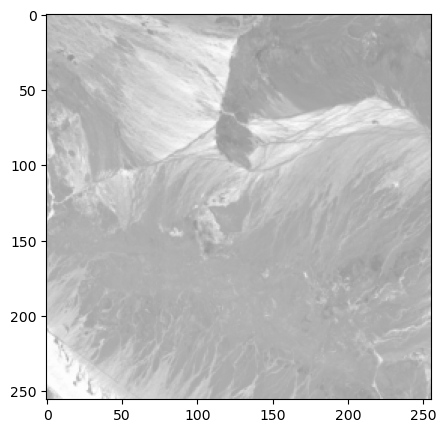

In [108]:
transform = T.ToPILImage()
image = transform(patch[0:2,:,:])
# image = transform(tensor)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()

In [109]:
train_set.training_data

True

In [94]:
torch.cuda.is_available()

True

In [98]:
len(train_set.observations), len(train_set.centroids)

(17173, 17173)

In [110]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=8,  num_workers=8)

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Test BCELoss

In [148]:
batch_size = 8

loss_fn = torch.nn.BCELoss()

# outputs_before_sigmoid = torch.randn(batch_size, num_classes)
outputs_before_sigmoid = torch.randn(num_classes, dtype=float)
sigmoid_outputs = torch.sigmoid(outputs_before_sigmoid)
# target_classes = torch.randint(0, 2, (batch_size, num_classes),dtype=torch.float)  # randints in [0, 2).

# target_classes = torch.tensor([[1.0],[0.0]])
# sigmoid_outputs = torch.tensor([[0.8],[0.]])
print(len(sigmoid_outputs), len(target))
# print(type(sigmoid_outputs), type(torch.from_numpy(target)))
loss = loss_fn(sigmoid_outputs, target)
print(loss)

5079 5079
tensor(0.7942, dtype=torch.float64)


In [132]:
torch.from_numpy(target)

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

# CNN

In [225]:
sys.path.insert(0, '/home/jovyan/sdm-geolifeCLEF/models/')

In [232]:
# model params
DROPOUT = 0.7
N_LABELS = num_classes
N_INPUTS = patch.shape[0]


In [240]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
%autoreload 2
from inception_env import InceptionEnv

In [241]:
# CONSTRUCT MODEL
model = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)

#Load model on GPU
if torch.cuda.is_available():
    # check if GPU is available
    print("Training on GPU")
    model = model.to(device)
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
else:
    print("Training on CPU")


Training on GPU


In [236]:
from torchsummary import summary

In [246]:
summary(model, (N_INPUTS, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 80, 64, 64]          22,320
       BatchNorm2d-2           [-1, 80, 64, 64]             160
       BasicConv2d-3           [-1, 80, 64, 64]               0
            Conv2d-4           [-1, 80, 64, 64]          57,600
       BatchNorm2d-5           [-1, 80, 64, 64]             160
       BasicConv2d-6           [-1, 80, 64, 64]               0
            Conv2d-7          [-1, 100, 64, 64]          72,000
       BatchNorm2d-8          [-1, 100, 64, 64]             200
       BasicConv2d-9          [-1, 100, 64, 64]               0
           Conv2d-10          [-1, 124, 64, 64]          12,400
      BatchNorm2d-11          [-1, 124, 64, 64]             248
      BasicConv2d-12          [-1, 124, 64, 64]               0
           Conv2d-13          [-1, 192, 64, 64]         214,272
      BatchNorm2d-14          [-1, 192,

### Debug: setting paths for imports

In [247]:
import sys
for path in sys.path:
    print(path)

/home/jovyan/sdm-geolifeCLEF/models/
/home/jovyan/sdm-geolifeCLEF/raster
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages


In [223]:
# sys.path.remove('/models')
sys.path.remove('/raster')
# sys.path.remove('model/')
# sys.path.remove('models/')
# sys.path.remove('/models')
# sys.path.remove('/raster')
